I am building char-lebel Transformer for learning purpose. I have implemented GPT2 arch from ground using pytorch. I want to extend it to LLAMA2 arch.

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great project! Extending from GPT-2 to LLaMA 2 architecture is an excellent way to understand the evolution of transformer models.

Before we dive in, let me understand where you're at:

1. Have you already looked into the key architectural differences between GPT-2 and LLaMA 2?
2. Which specific components are you planning to modify first?

The main differences include:
- **RMSNorm** instead of LayerNorm
- **RoPE** (Rotary Position Embeddings) instead of learned positional embeddings
- **SwiGLU** activation in the FFN instead of GELU
- **Grouped Query Attention (GQA)** instead of standard multi-head attention

Which of these would you like to start with, or would you prefer a different order based on what makes sense for your learning goals?

In [ ]:
#| default_exp Llam2

In [1]:
try:
    import google.colab
    !pip install -q git+https://github.com/tripathysagar/NanoTransformer.git
except Exception as e:
    pass

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
#|export
from NanoTransformer.data import *

In [3]:
#|export
from dataclasses import dataclass
import torch

@dataclass
class LlamaConfig:
    bs = 256
    seq_len = 128                # context length
    embedding_dim = 128          # dim of the embedding layer
    n_layers = 4                # no of decoder block stack on top of each other
    n_heads = 8                 # no of heads in a single decoder block
    vocab_size = len(tokenizer.vocab)
    dropout = 0.1

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 8 else torch.float16 # Use bfloat16 on Ampere+ GPUs, otherwise use float16

    lr = 1e-3
    max_grad_norm = 1.0

    epochs = 30
    no_kv = 1

    max_lr = 5e-4
    min_lr = 1e-4

llamaConfig = LlamaConfig()

In [4]:
#|export
text_dls = get_text_dl(bs=llamaConfig.bs, seq_len=llamaConfig.seq_len)
text_dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x7eb6f0d67530>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7eb6f1488bf0>}

In [5]:
#|export
llamaConfig.max_steps = len(text_dls['train']) * llamaConfig.epochs
llamaConfig.warm_steps = int(llamaConfig.max_steps * 0.1)

## Embedding

In [6]:
#|export
from torch import nn
class Embedding(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()
        self.register_buffer('pos_ids', torch.arange(config.seq_len))  # for adding the postional encoding from 0 to seq_len - 1

        self.embed = nn.Embedding(config.vocab_size, config.embedding_dim)

    def forward(self, x):           #bs * seq_len
        return self.embed(x)        #bs * seq_len * embedding_dim

## RoPE


In [7]:
#|export
class RoPE(nn.Module):
    def __init__(self, head_dim, seq_len):
        super().__init__()
        self.head_dim = head_dim
        self.seq_len = seq_len

        no = torch.arange(head_dim // 2)
        theta = 1.0 / (10000 ** (2 * no / head_dim ))    # angle

        # Position indices
        positions = torch.arange(seq_len)
        angles = positions[:, None] * theta             # (seq_len, emb_dim//2)

        self.register_buffer('cos_angles', torch.cos(angles))
        self.register_buffer('sin_angles', torch.sin(angles))

    def forward(self, x):
        bs, seq_len, head_dim = x.shape # emb_dim is a name bug but it head_dim is passed

        x1, x2 = x[..., :head_dim//2], x[..., head_dim//2:] # hf implement by deviding the emb in two half and then caluclate the rotation

        rotated_x1 = x1 * self.cos_angles[:seq_len] - x2 * self.sin_angles[:seq_len]
        rotated_x2 = x1 * self.sin_angles[:seq_len] + x2 * self.cos_angles[:seq_len]

        return  torch.cat([rotated_x1, rotated_x2], dim=-1)


In [8]:
emb = Embedding(llamaConfig)
rope = RoPE(head_dim = 128/8, seq_len=llamaConfig.seq_len)

for x, y in text_dls['train']:
    break

emb_x = emb(x)

x.shape, y.shape, emb_x.shape

(torch.Size([256, 128]), torch.Size([256, 128]), torch.Size([256, 128, 128]))

In [9]:
assert x.shape == y.shape
assert x.shape == emb_x.shape[:-1]
assert emb_x.shape[-1] == llamaConfig.embedding_dim

In [10]:
head = emb_x[...,:16]
pos = rope(head)
assert pos.shape == head.shape

## RMSNorm

What are the formula of `RMSNorm`?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

RMSNorm (Root Mean Square Layer Normalization) is simpler than LayerNorm. Here's the formula:

**RMSNorm(x) = (x / RMS(x)) × γ**

Where:
- **RMS(x) = √(mean(x²) + ε)**
- **γ** is a learnable scale parameter (same shape as the feature dimension)
- **ε** is a small constant for numerical stability (typically 1e-5 or 1e-6)

The key difference from LayerNorm is that RMSNorm:
- Does **not** subtract the mean (no centering)
- Does **not** have a bias term
- Only normalizes by the root mean square

So in code terms, for each token embedding, you'd compute the RMS across the embedding dimension, divide by it, then multiply by the learned scale parameter.

Would you like to implement this now, or do you have questions about how it works?

In [11]:
class RMSNorm(nn.Module):
    def __init__(self, shape, eps=1e-5):
        super().__init__()
        self.scale_param = nn.Parameter(torch.ones(shape))
        self.eps = eps
    def forward(self, x):
        rms = torch.sqrt((x*x).mean(dim=-1, keepdim=True) + self.eps)
        return (x / rms ) * self.scale_param

In [12]:
rms_norm = RMSNorm(llamaConfig.embedding_dim)
normalized = rms_norm(emb_x)
assert normalized.shape == emb_x.shape

## SwiGLU activation in the FFN instead of GELU

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Now let's look at **SwiGLU**, which replaces GELU in the feedforward network.

**SwiGLU formula:**

SwiGLU(x, W, V, W₂) = (Swish(xW) ⊙ xV) W₂

Where:
- **Swish(x) = x × σ(x)** where σ is the sigmoid function (also called SiLU in PyTorch)
- **⊙** means element-wise multiplication
- **W, V, W₂** are weight matrices

The key difference from a standard FFN:
- GPT-2 FFN: `x → Linear → GELU → Linear → output`
- LLaMA FFN: `x → [Linear(W), Linear(V)] → SwiGLU → Linear(W₂) → output`

Notice that SwiGLU uses **two parallel projections** (W and V) before combining them, so the hidden dimension typically needs adjustment.

In LLaMA, the FFN hidden dimension is usually `(4 * embedding_dim * 2) / 3` rounded to a multiple of the model's dimension.

Would you like to implement the SwiGLU FFN block now, or do you have questions about how it differs from the standard FFN?

In [13]:
import torch.nn.functional as F
class SwiGLU_FFN(nn.Module):
    def __init__(self, embedding_dim, dropout=0.1):
        super().__init__()
        hidden_dim = int(2 * embedding_dim * 4 / 3)
        self.w = nn.Linear(embedding_dim, hidden_dim, bias=False)
        self.v = nn.Linear(embedding_dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, embedding_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.w2(F.silu(self.w(x)) * self.v(x)))

## Grouped Query Attention

**Q and K after projection, but before computing attention scores**.

Specifically:
- Apply RoPE to **Q** (after `self.Q_W(x)` in `AttentionHead`)
- Apply RoPE to **K** (in your `GroupedQueryAttention` class, after `self.K_cache(x)` and reshaping)
- Do **NOT** apply RoPE to **V**

So in your current code, you'd need to:
1. Apply RoPE to K in the `GroupedQueryAttention.forward()` method before passing to heads
2. Apply RoPE to Q inside `AttentionHead.forward()` after creating Q

One thing to consider: your RoPE class expects shape `(bs, seq_len, head_dim)`. Will this work when K has shape `(bs, seq_len, no_kv, head_dim)`?


Yes consider the example
```py
class AttentionHead(nn.Module):
    def __init__(self, config:GPTConfig):
        super().__init__()

        assert config.embedding_dim % config.n_heads == 0
        self.head_dim = config.embedding_dim // config.n_heads

        self.Q_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.K_W = nn.Linear(config.embedding_dim, self.head_dim)
        self.V_W = nn.Linear(config.embedding_dim, self.head_dim)


        mask = torch.tril(torch.ones(config.seq_len, config.seq_len))
        self.register_buffer('mask', mask.masked_fill(mask == 0, float('-inf'))) # for building casual mask

        self.dropout = nn.Dropout(p = config.dropout)

    def forward(self, x): #bs * seq_len * embedding_dim

        Q, K, V = self.Q_W(x), self.K_W(x), self.V_W(x)        #bs * seq_len * head_dim

        attn = Q @ K.transpose(-2, -1) /  self.head_dim ** 0.5         #bs * seq_len * head_dim @ bs * head_dim * seq_len -> bs * seq_len * seq_len

        attn += self.mask[:x.shape[1], :x.shape[1]]

        attn = torch.softmax(attn, dim=-1)

        return self.dropout(attn @ V)         # bs * seq_len * seq_len @ bs * seq_len * head_dim -> bs * seq_len *  head_dim
```

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good! This is a single attention head from GPT-2 style architecture.

For **Grouped Query Attention**, the key change is: instead of having one K and V projection per query head, you'll have **fewer K/V heads that are shared across multiple Q heads**.

For example, with 8 query heads and 2 K/V heads:
- Q heads: 8 (each gets `head_dim` dimensions)
- K heads: 2 (shared across groups of 4 Q heads each)
- V heads: 2 (shared across groups of 4 Q heads each)

So in your `MultiHeadAttention` module (not the single head), you'd need to:
1. Project Q to get all 8 heads
2. Project K to get only 2 heads
3. Project V to get only 2 heads
4. During attention computation, repeat/expand the K and V heads to match Q

Before we code this, a few questions:
1. Do you currently have a `MultiHeadAttention` class that combines multiple `AttentionHead` instances?
2. How many K/V heads do you want to use? (Common choices: 2, 4, or 8)
3. Do you want to try implementing the GQA structure yourself first, or would you like me to write the code for you?

K and V will be shared to AttentionHead ?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Yes, exactly! In GQA, multiple query heads will **share** the same K and V heads.

Here's the key insight:
- In standard MHA: each attention head has its own Q, K, and V
- In GQA: each attention head has its own Q, but **groups of heads share** the same K and V

So if you have 8 Q heads and 2 K/V heads:
- Q heads 0-3 share K/V head 0
- Q heads 4-7 share K/V head 1

This means you'll likely want to restructure your code. Instead of having separate `AttentionHead` classes, you'd typically implement this in a single `GroupedQueryAttention` module that:
1. Projects Q to shape `(bs, seq_len, n_heads, head_dim)`
2. Projects K and V to shape `(bs, seq_len, n_kv_heads, head_dim)`
3. Expands/repeats K and V to match the number of Q heads
4. Computes attention for all heads in parallel

Does this make sense? Would you like to try implementing this yourself, or would you like me to show you the code structure?

In [14]:

class AttentionHead(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()

        assert config.embedding_dim % config.n_heads == 0
        self.head_dim = config.embedding_dim // config.n_heads

        self.Q_W = nn.Linear(config.embedding_dim, self.head_dim)
        #self.K_W = nn.Linear(config.embedding_dim, self.head_dim)
        #self.V_W = nn.Linear(config.embedding_dim, self.head_dim)

        self.rope = RoPE(head_dim = self.head_dim, seq_len = config.seq_len)

        mask = torch.tril(torch.ones(config.seq_len, config.seq_len))
        self.register_buffer('mask', mask.masked_fill(mask == 0, float('-inf'))) # for building casual mask

        self.dropout = nn.Dropout(p = config.dropout)

    def forward(self, K, V, x): #bs * seq_len * embedding_dim

        Q = self.Q_W(x)        #bs * seq_len * head_dim

        attn = self.rope(Q) @ K.transpose(-2, -1) /  self.head_dim ** 0.5         #bs * seq_len * head_dim @ bs * head_dim * seq_len -> bs * seq_len * seq_len

        attn += self.mask[:x.shape[1], :x.shape[1]]

        attn = torch.softmax(attn, dim=-1)

        return self.dropout(attn @ V)         # bs * seq_len * seq_len @ bs * seq_len * head_dim -> bs * seq_len *  head_dim

check the implementaion

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Good start! You've modified `AttentionHead` to accept K and V as inputs instead of computing them internally. This is the right direction for GQA.

However, there's a dimension issue to watch out for. When you pass K and V into this head, what shape are you expecting them to have?

Currently your code assumes:
- Q: `(bs, seq_len, head_dim)`
- K: needs to be `(bs, head_dim, seq_len)` after transpose for the matmul to work
- V: needs to be `(bs, seq_len, head_dim)` for the final matmul

But in GQA, K and V will be shared across multiple heads. So you'll need to think about how to handle the broadcasting or indexing.

A few questions to help you move forward:
1. Are you planning to create a `MultiHeadAttention` or `GroupedQueryAttention` class that will manage multiple `AttentionHead` instances?
2. How are you planning to generate the shared K and V tensors - will you project them in the parent class?
3. Have you thought about how many K/V heads you want (e.g., 2, 4, or 8)?

What's your plan for the overall structure?


But in GQA, K and V will be shared across multiple heads. So you'll need to think about how to handle the broadcasting or indexing.

A few questions to help you move forward:
1. Are you planning to create a `MultiHeadAttention` or `GroupedQueryAttention` class that will manage multiple `AttentionHead` instances? : yes
2. How are you planning to generate the shared K and V tensors - will you project them in the parent class? : yes and share them accross attention head
3. Have you thought about how many K/V heads you want (e.g., 2, 4, or 8)? : let make it 8for now


##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Perfect! So with 8 Q heads and 8 K/V heads, you're actually doing **Multi-Head Attention** (not GQA yet), which is a good place to start.

Here's what you need in your parent `MultiHeadAttention` class:

1. Create K and V projections that output the full dimension: `nn.Linear(embedding_dim, embedding_dim)`
2. Split the K and V outputs into 8 heads of `head_dim` each
3. Pass each K head and V head to the corresponding `AttentionHead`

So in your parent class, after projecting K and V, you'd reshape them from:
- `(bs, seq_len, embedding_dim)`
to:
- `(bs, seq_len, n_heads, head_dim)`

Then you can pass `K[:, :, i, :]` and `V[:, :, i, :]` to the i-th attention head.

Does this approach make sense? Would you like to try implementing the `MultiHeadAttention` class yourself, or do you need more guidance on the reshaping part?

For GroupedQueryAttention

```python
i = idx // (self.config.n_heads // self.no_kv)
```

This properly maps multiple query heads to share K/V pairs. For example, with 8 heads and 2 K/V pairs:
- Heads 0-3 get `i=0`
- Heads 4-7 get `i=1`

In [15]:
class GroupedQueryAttention(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()
        self.config = config
        assert config.embedding_dim % config.n_heads == 0 # config.n_heads * output of the embedding layer
        assert config.n_heads % config.no_kv == 0                    # checikng the kv is equally divisible by no of heads
        self.head_dim = config.embedding_dim // config.n_heads

        self.heads = nn.ModuleList([AttentionHead(config) for _ in range(config.n_heads)])

        self.K_cache = nn.Linear(config.embedding_dim, self.head_dim * config.no_kv)
        self.V_cache = nn.Linear(config.embedding_dim, self.head_dim * config.no_kv)

        self.dropout = nn.Dropout(p=config.dropout)
        self.linear_MHA = nn.Linear(config.embedding_dim, config.embedding_dim)

        self.rope = RoPE(head_dim = self.head_dim, seq_len = config.seq_len)


    def forward(self, x): #bs * seq_len * embedding_dim
        bs, seq_len, _ = x.shape

        K = self.K_cache(x)    # #bs * seq_len * (head_dim * no_kv)
        V = self.V_cache(x)    # #bs * seq_len * (head_dim * no_kv)

        K, V = K.view(bs, seq_len, self.config.no_kv, self.head_dim), V.view(bs, seq_len, self.config.no_kv, self.head_dim)
        heads = []

        for idx, head in enumerate(self.heads):
            i = idx // (self.config.n_heads // self.config.no_kv)
            heads.append(head(self.rope(K[:,:,i,:]), V[:,:,i,:], x))

        head = torch.cat(heads, dim=-1)                                #bs * seq_len * embedding_dim
        head = self.dropout(self.linear_MHA(head))                     #bs * seq_len * embedding_dim
        return head


In [16]:
gqa = GroupedQueryAttention(llamaConfig)
gqa(emb_x[:1]).shape

torch.Size([1, 128, 128])

any thing else i am missing ? Or should we move to build the finaldecoder model

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Nice work! Your GQA implementation looks solid. Just one small thing to consider:

You're applying RoPE to K in the parent class (`self.rope(K[:,:,i,:])`), but also applying RoPE to Q inside `AttentionHead`. That's correct! Both Q and K should get RoPE applied.

However, double-check that you're **not** applying RoPE to V - only Q and K should be rotated.

Other than that, you have all the key LLaMA components:
- ✅ RMSNorm
- ✅ RoPE
- ✅ SwiGLU FFN
- ✅ Grouped Query Attention

Ready to build the decoder block and stack them? Or do you want to test anything first?

## Decoder Block

Lets go for decoder block?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great! Let's build the decoder block.

In LLaMA, each decoder block has this structure:

1. **RMSNorm** → **Grouped Query Attention** → **Residual connection**
2. **RMSNorm** → **SwiGLU FFN** → **Residual connection**

You already have most of this in your `GroupedQueryAttention` class (you're doing RMSNorm + residual at the end). But typically in LLaMA, the normalization happens **before** the sublayer (pre-norm), not after.

So the pattern is:
```
x = x + attention(RMSNorm(x))
x = x + ffn(RMSNorm(x))
```

Do you want to:
1. Refactor your `GroupedQueryAttention` to remove the RMSNorm and residual (so it just returns the attention output)?
2. Then create a `DecoderBlock` that handles the RMSNorm and residuals for both attention and FFN?

Or would you prefer to keep your current structure and adjust the decoder block accordingly?

In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()
        self.attn_norm = RMSNorm(config.embedding_dim)
        self.attn = GroupedQueryAttention(config)
        self.ffn_norm = RMSNorm(config.embedding_dim)
        self.ffn = SwiGLU_FFN(config.embedding_dim, config.dropout)
    def forward(self, x):
        x = x + self.attn(self.attn_norm(x))
        return x + self.ffn(self.ffn_norm(x))

In [18]:
decode = DecoderBlock(llamaConfig)
decode(emb_x[:1]).shape

torch.Size([1, 128, 128])

## Final Model

In [19]:
class LlamaText(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()

        self.embed = Embedding(config)
        self.blocks = nn.ModuleList(
            [DecoderBlock(config) for _ in range(config.n_layers)])
        self.final_norm = RMSNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.final_norm(x))

Check the above implementation

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Excellent! Your LLaMA implementation looks great. The structure is correct:

1. ✅ Embedding layer (without positional embeddings - RoPE handles that)
2. ✅ Stack of decoder blocks with pre-norm architecture
3. ✅ Final RMSNorm before the output
4. ✅ Language modeling head to project back to vocab size

The architecture matches LLaMA's design. A couple of things to verify:

1. In your `GroupedQueryAttention` class, you have `self.linear_MHA` and `self.dropout` at the end - is that the output projection? That's good, just making sure it's there.

2. Your `DecoderBlock` looks clean with the pre-norm pattern.

Have you tested the full forward pass yet? Try running:
```python
model = LlamaText(llamaConfig)
output = model(x)
```

Does it produce the expected shape `(bs, seq_len, vocab_size)`?

In [20]:
model = LlamaText(llamaConfig)
output = model(x[:1])
output.shape

torch.Size([1, 128, 65])

## Lets disscuss about weight init?

##### 🤖Reply🤖<!-- SOLVEIT_SEPARATOR_7f3a9b2c -->

Great topic! Weight initialization is crucial for training stability and convergence.

For LLaMA-style models, there are a few key initialization strategies to consider:

1. **Embedding layers** - typically initialized from a normal distribution
2. **Linear layers** - Xavier/Kaiming initialization
3. **Output projection scaling** - often scaled by 1/√(2*n_layers) to account for residual connections
4. **RMSNorm scale parameters** - initialized to 1.0 (which you already have)

What aspect would you like to focus on first? Or do you have specific questions about which layers need special initialization treatment?

In [21]:
model

LlamaText(
  (embed): Embedding(
    (embed): Embedding(65, 128)
  )
  (blocks): ModuleList(
    (0-3): 4 x DecoderBlock(
      (attn_norm): RMSNorm()
      (attn): GroupedQueryAttention(
        (heads): ModuleList(
          (0-7): 8 x AttentionHead(
            (Q_W): Linear(in_features=128, out_features=16, bias=True)
            (rope): RoPE()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (K_cache): Linear(in_features=128, out_features=16, bias=True)
        (V_cache): Linear(in_features=128, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear_MHA): Linear(in_features=128, out_features=128, bias=True)
        (rope): RoPE()
      )
      (ffn_norm): RMSNorm()
      (ffn): SwiGLU_FFN(
        (w): Linear(in_features=128, out_features=341, bias=False)
        (v): Linear(in_features=128, out_features=341, bias=False)
        (w2): Linear(in_features=341, out_features=128, bias=False)
        (dropout): Dro

## Final LLAMA model

In [22]:
#|export
class LlamaText(nn.Module):
    def __init__(self, config:LlamaConfig):
        super().__init__()
        self.config = config

        self.embed = Embedding(config)
        self.blocks = nn.ModuleList(
            [DecoderBlock(config) for _ in range(config.n_layers)])
        self.final_norm = RMSNorm(config.embedding_dim)
        self.lm_head = nn.Linear(config.embedding_dim, config.vocab_size)

        self._init_weights()

    def forward(self, x):
        x = self.embed(x)
        for block in self.blocks:
            x = block(x)
        return self.lm_head(self.final_norm(x))


    def _init_weights(self):
        """Init"""
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                std = 0.02
                # Scale down residual projections
                if 'linear_MHA' in name or 'w2' in name:
                    std = 0.02 / ((2 * self.config.n_layers) ** 0.5)

                module.weight.data.normal_(mean=0.0, std=std)
                if module.bias is not None:
                    module.bias.data.zero_()

            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=0.02)

    def decay_params(self):
        """
        get decay params
        """
        no_decay_params, decay_params = [], []
        for name, param in self.named_parameters():
            if 'bias' in name or 'norm' in name or 'embed' in name:
                no_decay_params.append(param)
            else:
                decay_params.append(param)

        return decay_params, no_decay_params


In [23]:
len(text_dls['train'])

31

In [24]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=2.01)

pg = list(optimizer.param_groups)

In [25]:
pg[0].keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused', 'decoupled_weight_decay'])

In [26]:
#|export
from torch.optim import AdamW
class Optim:
    def __init__(self, model, config:LlamaConfig):
        decay_params, no_decay_params = model.decay_params() # extract deacayable and non deacayable params

        self.optim = optimizer = AdamW([
            {'params': decay_params, 'weight_decay': 0.1},
            {'params': no_decay_params, 'weight_decay': 0.0}
        ], lr=config.min_lr)

    def config_lr(self, step):
        for param_group in self.optim.param_groups:
            param_group['lr'] = get_cosine_lr(step)

    def step(self): self.optim.step()

    def zero(self): self.optim.zero_grad()

In [27]:
#|export

import math
def get_cosine_lr(
    step,
    warmup_steps=llamaConfig.warm_steps,
    max_steps=llamaConfig.max_steps,
    max_lr=llamaConfig.max_lr,
    min_lr=llamaConfig.min_lr
    ):
    if step < warmup_steps:
        return min_lr + (max_lr - min_lr) * step / warmup_steps
    elif step < max_steps:
        progress = (step - warmup_steps) / (max_steps - warmup_steps)
        return min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(math.pi * progress))
    else:
        return min_lr


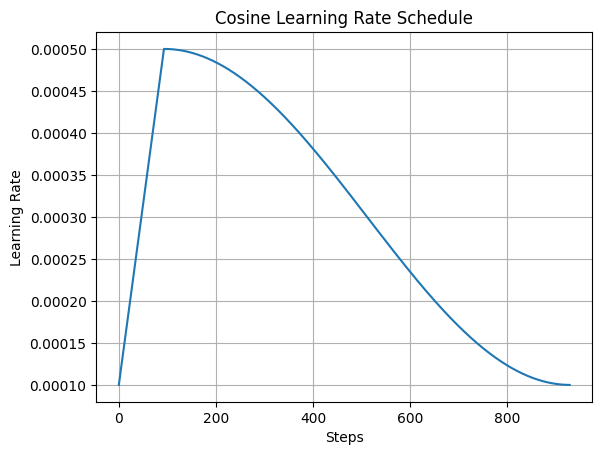

In [28]:
steps = torch.arange(llamaConfig.max_steps)
lrs = [get_cosine_lr(step) for step in steps]

import matplotlib.pyplot as plt
plt.plot(steps, lrs)
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Cosine Learning Rate Schedule')
plt.grid(True)
plt.show()

In [29]:
#|export
from torch.nn.utils import clip_grad_norm_
loss_func = nn.CrossEntropyLoss()
def train(model):
    model = model.to(llamaConfig.device)

    optimizer = Optim(model, llamaConfig)

    step = 0
    for epoch in range(llamaConfig.epochs):
        model.train()
        train_loss, no_train = 0, 0

        for x, y in text_dls['train']: # Iterate directly over
            step += 1
            no_train += 1

            x, y = x.to(llamaConfig.device), y.to(llamaConfig.device)           # move to device

            optimizer.config_lr(step)                                           # set lr for each step
            optimizer.zero()

            with torch.autocast(device_type=llamaConfig.device, dtype=llamaConfig.dtype):
              logits = model(x)

              loss = loss_func(logits.reshape(-1, llamaConfig.vocab_size), y.reshape(-1))

            loss.backward()

            clip_grad_norm_(model.parameters(), llamaConfig.max_grad_norm) # to clip gradients

            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss, no_valid = 0, 0
        with torch.no_grad(), torch.autocast(device_type=llamaConfig.device, dtype=llamaConfig.dtype):
            for x, y in text_dls['valid']:
                no_valid += 1

                x, y = x.to(llamaConfig.device), y.to(llamaConfig.device)

                logits = model(x)
                loss = loss_func(logits.reshape(-1, llamaConfig.vocab_size), y.reshape(-1))

                val_loss += loss.item()

        print(f"{epoch} -> {train_loss/no_train:.4f} : {val_loss/no_valid:.4f}")



## Inferenece

In [30]:
@torch.no_grad()
def generate(prompt, max_new_tokens=100, temperature=1.0):
    """
    prompt: string to start generation
    max_new_tokens: how many tokens to generate
    temperature: higher = more random, lower = more deterministic
    """
    model.eval()
    tokens = tokenizer.encode(prompt)
    tokens = torch.tensor(tokens).unsqueeze(0)  # Add batch dim
    tokens = tokens.to(llamaConfig.device)
    for _ in range(max_new_tokens):
        # Crop to last seq_len tokens if needed
        context = tokens if tokens.size(1) <= model.embed.pos_ids.size(0) else tokens[:, -model.embed.pos_ids.size(0):]

        # Get predictions
        with torch.no_grad(), torch.autocast(device_type=llamaConfig.device, dtype=torch.bfloat16):
          logits = model(context)
        logits = logits[:, -1, :] / temperature  # Focus on last token

        # Sample next token
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)

        # Append to sequence
        tokens = torch.cat([tokens, next_token], dim=1)

    return tokenizer.decode(tokens.squeeze().tolist())

In [31]:
model = LlamaText(llamaConfig)
train(model)

0 -> 3.5532 : 3.1582
1 -> 2.9167 : 2.7385
2 -> 2.6159 : 2.4935
3 -> 2.4004 : 2.2873
4 -> 2.2113 : 2.1347
5 -> 2.0416 : 2.0048
6 -> 1.9092 : 1.9156
7 -> 1.8110 : 1.8543
8 -> 1.7330 : 1.8040
9 -> 1.6719 : 1.7541
10 -> 1.6245 : 1.7303
11 -> 1.5846 : 1.7028
12 -> 1.5526 : 1.6750
13 -> 1.5285 : 1.6664
14 -> 1.5066 : 1.6412
15 -> 1.4903 : 1.6271
16 -> 1.4741 : 1.6202
17 -> 1.4606 : 1.6131
18 -> 1.4481 : 1.6053
19 -> 1.4386 : 1.5980
20 -> 1.4296 : 1.5936
21 -> 1.4218 : 1.5851
22 -> 1.4143 : 1.5807
23 -> 1.4089 : 1.5784
24 -> 1.4031 : 1.5749
25 -> 1.3983 : 1.5711
26 -> 1.3948 : 1.5670
27 -> 1.3907 : 1.5680
28 -> 1.3869 : 1.5641
29 -> 1.3842 : 1.5632


1. no_kv = 8 : `29 -> 1.3763 : 1.5724`
1. no_kv = 4 : `29 -> 1.3781 : 1.5566`
1. no_kv = 2 : `29 -> 1.3955 : 1.5710`
1. no_kv = 1 : `29 -> 1.3842 : 1.5632`



In [33]:
print(generate("To be or not to be", max_new_tokens=512))

To be or not to be now, let
they say.

First Citizen:
None, and thou hast never as his suppose,
With hate the eyes of my love's lipful might
brave the certains. W, not the prince, which in the bislant
Partilys and worruples that my blame bold,
And being cursed from to my son and with itself
The God of love.

GREMIO:
As come to the gentle his ZorINGFNnet with oyself,
So first he chide him, that thou hast thou, is zens
Rejeiks to your grace!

VOLUMNIA:
No, good that as Barnardins, did repent,
The sewSs of Parisia pr'd me on us
